### Problem Statement
##### Classifying Bank Customers who will churn or not
##### Exited 0 indicates Customer will not churn
##### Exited 1 indicates Customer will churn

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mutual_info_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

### Data Ingestion 
#### Dataset was obtained from kaggle
#### https://www.kaggle.com/datasets/rohitudageri/credit-card-details?select=Credit_card.csv

In [117]:
df = pd.read_csv("Customer-Churn-Records.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,5,DIAMOND,484
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0,0,2,SILVER,206
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1,2,DIAMOND,282
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,0,3,GOLD,251
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,0,3,GOLD,342


### Data Preparation and Wrangling

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [119]:
df.shape

(10000, 18)

In [120]:
#change the column headers into lower case
df.columns = df.columns.str.lower().str.lower().str.replace(' ','_')

In [121]:
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'complain',
       'satisfaction_score', 'card_type', 'point_earned'],
      dtype='object')

In [122]:
#drop columns rownumber and surname
df = df.drop(columns = ['rownumber', 'surname'],axis = 1)

In [126]:
#check for duplicate and null values
df.duplicated().sum()

0

In [127]:
df.isna().sum()

customerid            0
creditscore           0
geography             0
gender                0
age                   0
tenure                0
balance               0
numofproducts         0
hascrcard             0
isactivemember        0
estimatedsalary       0
exited                0
complain              0
satisfaction_score    0
card_type             0
point_earned          0
dtype: int64

In [128]:
df.nunique()

customerid            10000
creditscore             460
geography                 3
gender                    2
age                      70
tenure                   11
balance                6382
numofproducts             4
hascrcard                 2
isactivemember            2
estimatedsalary        9999
exited                    2
complain                  2
satisfaction_score        5
card_type                 4
point_earned            785
dtype: int64

In [124]:
features = list(df.columns)
features.remove('customerid')
features.remove('exited')

In [129]:
#display the descriptive statistics of the numeric data
df[features].describe().T

,count,mean,std,min,25%,50%,75%,max
creditscore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
numofproducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
hascrcard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
isactivemember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
estimatedsalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
complain,10000.0,0.204400,0.403283,0.00,0.00,0.000,0.0000,1.00
satisfaction_score,10000.0,3.013800,1.405919,1.00,2.00,3.000,4.0000,5.00


### Exploratory Data Analysis (EDA)

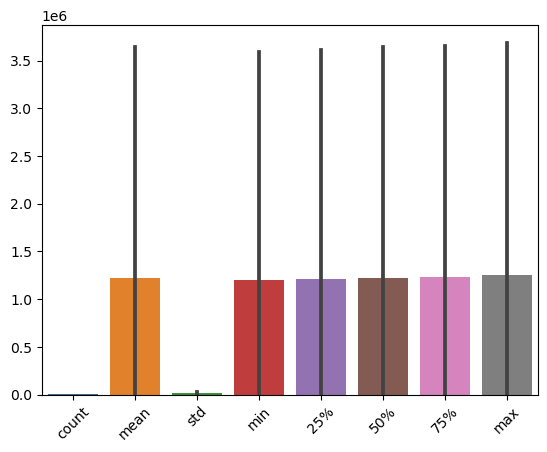

In [130]:
#plotting the dtatistical description of the numerical columns
description = df.describe().T
sns.barplot(data=description)
plt.xticks(rotation=45)
plt.show()

In [ ]:
numeric = list(df.select_dtypes(exclude=['object']).columns)
numeric.remove('exited')

In [139]:
numeric

['customerid',
 'creditscore',
 'age',
 'tenure',
 'balance',
 'numofproducts',
 'hascrcard',
 'isactivemember',
 'estimatedsalary',
 'complain',
 'satisfaction_score',
 'point_earned']

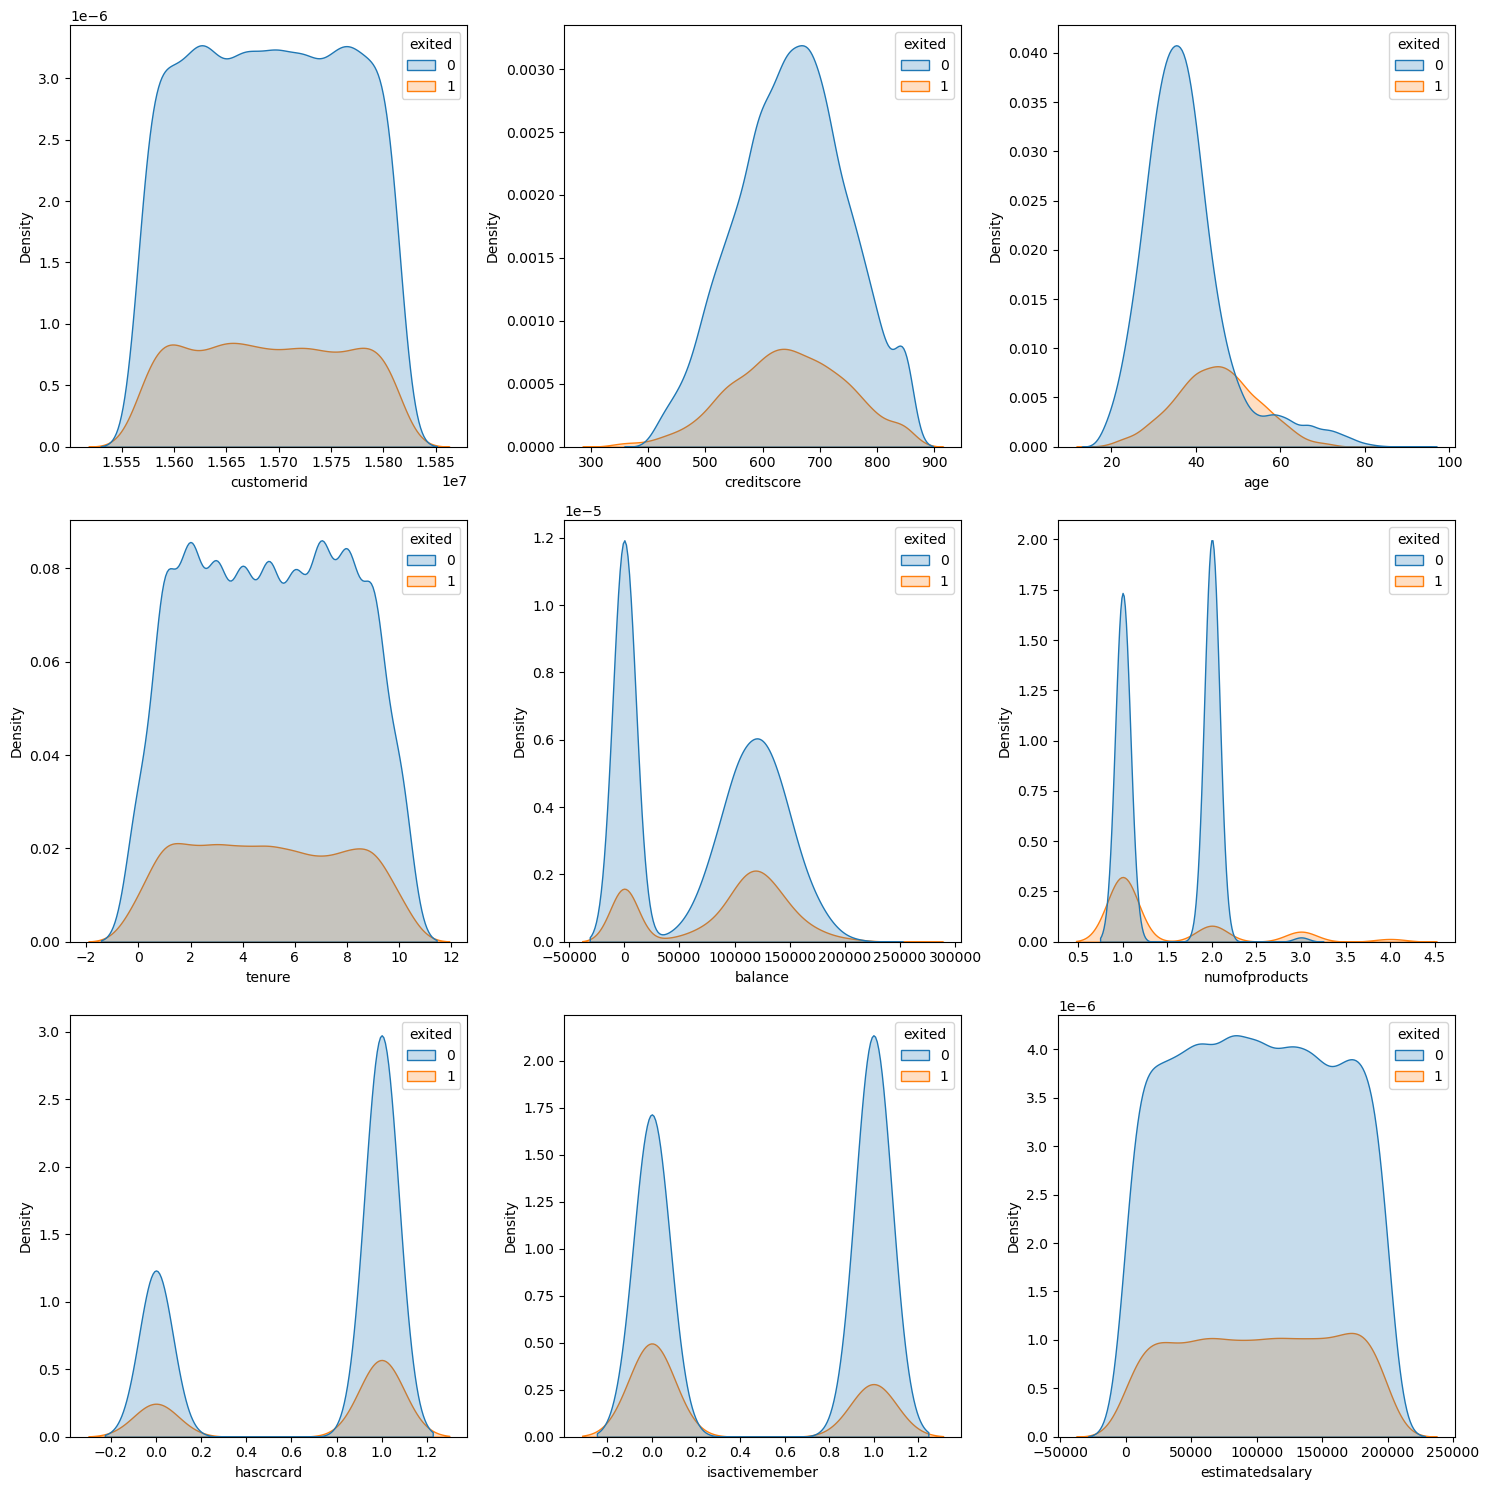

In [141]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
feature_id = 0

for i in range(3):
    for j in range(3):
        feature = numeric[feature_id]
        sns.kdeplot(df, x=feature, hue='exited', ax=axs[i, j], fill=True)
        feature_id += 1

plt.tight_layout()
plt.show()

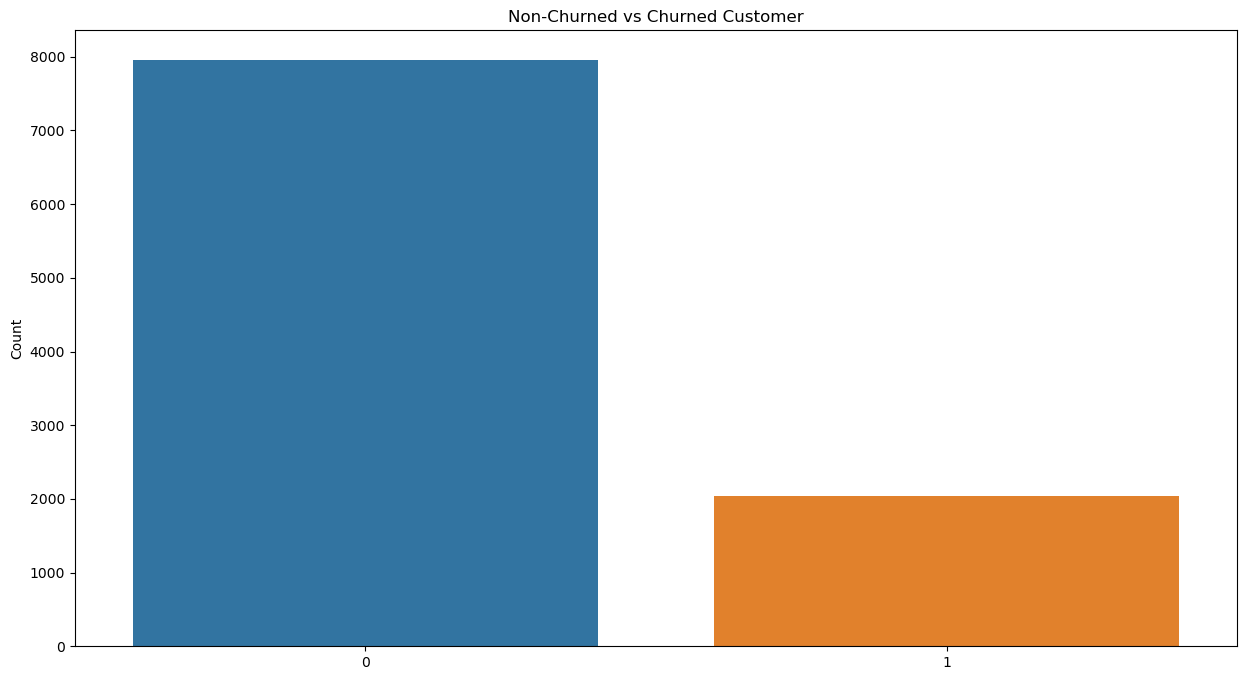

In [142]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=df['exited'].value_counts().index, y=df['exited'].value_counts().values)
plt.title("Non-Churned vs Churned Customer")
plt.ylabel('Count')
plt.xticks()
plt.show()

##### Insight: Number of Customers retained outweighs Churned Customers

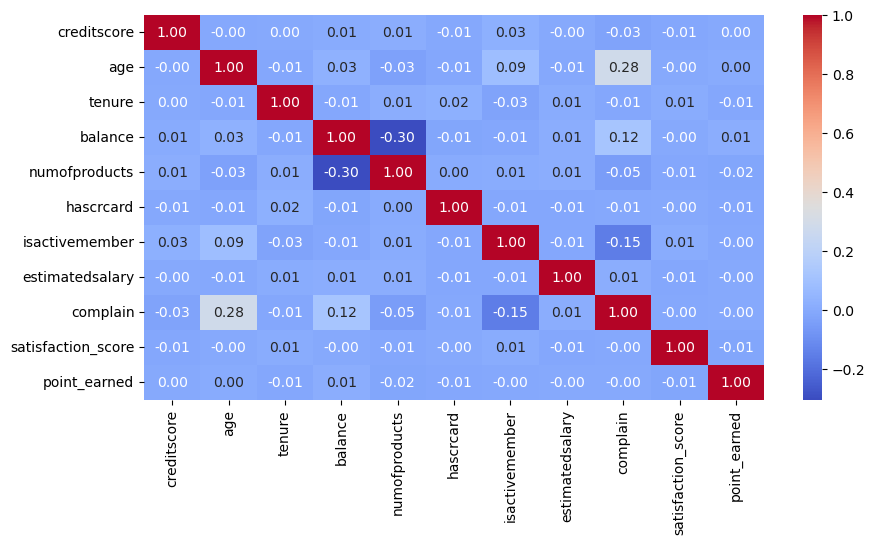

In [143]:
corr_matrix = df[features].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

##### Insight: There isn't high correlation between the features

#### Check correlation with 'exited' feature

In [144]:
df[features].corrwith(df['exited']).sort_values(key=abs, ascending=False)

complain              0.995693
age                   0.285296
isactivemember       -0.156356
balance               0.118577
numofproducts        -0.047611
creditscore          -0.026771
tenure               -0.013656
estimatedsalary       0.012490
hascrcard            -0.006976
satisfaction_score   -0.005849
point_earned         -0.004628
dtype: float64

##### Insight: 'complain' has the highest correlation with the target value

#### Split the Dataset into train(60%), test(20%), and val(20%)

In [145]:
#set SEED value = 42
SEED = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

In [146]:
len(df), len(df_full_train),len(df_test) ,len(df_train), len(df_val)

(10000, 8000, 2000, 6000, 2000)

In [147]:
# reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [148]:
#split the churn column from the rest of the dataframe
y_train = df_train.exited.values
y_val = df_val.exited.values
y_test = df_test.exited.values

In [149]:
del df_train['exited']
del df_val['exited']
del df_test['exited']

#### Feature Importance: Decline Rate and Risk ratio 
##### Identifying features that have higher effect on the target value
##### Decline Rate
##### Risk Ration
##### Mutual information

In [150]:
#global decline rate
total_churn_rate = df_full_train.exited.mean().round(2)
total_churn_rate

0.21

##### Risk Ratio
##### if the group_decline_rate / total_churn_rate > 1 -> the group(feature) is more likely to exit
##### if the group_decline_rate / total_churn_rate < 1 -> the group(feature) is less likely to exit

In [151]:
#create a new dataframe to perform Decline rate and risk ratio for the categorical columns
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).exited.agg(['mean', 'count'])
    df_group['diff'] = total_churn_rate - df_group['mean']
    df_group['risk'] =  df_group['mean'] /total_churn_rate 
    display(df_group)
    print()
    print()

geography


,mean,count,diff,risk
geography,,,,
France,0.162744,3994,0.047256,0.774972
Germany,0.323720,2011,-0.113720,1.541522
Spain,0.172431,1995,0.037569,0.821100




gender


,mean,count,diff,risk
gender,,,,
Female,0.252611,3638,-0.042611,1.202911
Male,0.166437,4362,0.043563,0.792559




card_type


,mean,count,diff,risk
card_type,,,,
DIAMOND,0.220559,2004,-0.010559,1.050280
GOLD,0.194097,1999,0.015903,0.924272
PLATINUM,0.204467,2015,0.005533,0.973650
SILVER,0.203330,1982,0.006670,0.968238


In [152]:
# separate the columns as categorical and numeical
numerical = [ 'creditscore','age',
    'tenure', 'balance', 'numofproducts', 'hascrcard',
    'isactivemember', 'estimatedsalary',
    'complain','satisfaction_score','point_earned'
]

categorical = ['geography','gender','card_type']

#### Feature Importance: Mutual information

In [153]:
def mutual_info_decline_rate(series):
    return mutual_info_score(series, y_train)

In [155]:
#categorical features
mutual_info = df_train[categorical].apply(mutual_info_decline_rate)
mutual_info.sort_values(ascending=False)

geography    0.013160
gender       0.004827
card_type    0.000491
dtype: float64

In [156]:
#numerical features
mutual_info_numerical = df_train[numerical].apply(mutual_info_decline_rate)
mutual_info_numerical.sort_values(ascending=False)

estimatedsalary       0.507482
complain              0.500281
balance               0.363034
age                   0.077609
point_earned          0.073415
numofproducts         0.071196
creditscore           0.042616
isactivemember        0.010832
tenure                0.001664
satisfaction_score    0.000045
hascrcard             0.000027
dtype: float64

In [157]:
#checking the roc_auc of numerical features for feature importance
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    print('%16s, %.3f' % (n, auc))

     creditscore, 0.513
             age, 0.729
          tenure, 0.506
         balance, 0.577
   numofproducts, 0.581
       hascrcard, 0.504
  isactivemember, 0.591
 estimatedsalary, 0.505
        complain, 0.999
satisfaction_score, 0.504
    point_earned, 0.511


### Insight: complain and age have the highest feature importance

##### plot the roc_curve of age and complain against y_train dataset

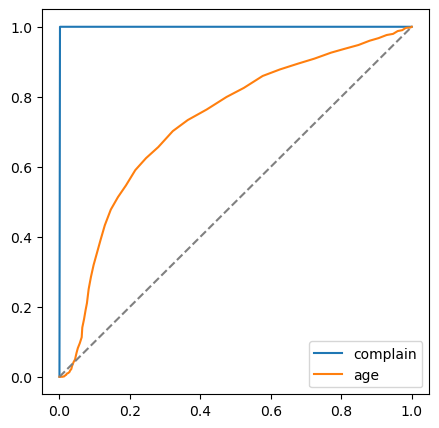

In [158]:

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.complain)
plt.plot(fpr, tpr, label='complain')

fpr, tpr, _ = roc_curve(y_train, df_train.age)
plt.plot(fpr, tpr, label='age')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

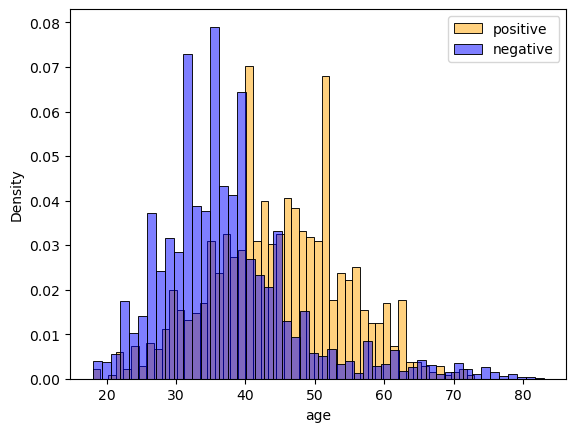

In [160]:
sns.histplot(df_train.age[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.age[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

#### train and prediction function 

In [161]:
def train(df_train, y_train,current_model, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = current_model
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### Model: Logistic Regression

In [162]:
lr = LogisticRegression(C=1.0, max_iter=1000)

#train the model
dv, model = train(df_train, y_train, lr)

#predict with the model
prediction = predict(df_val, dv, model)
prediction

array([0.09703761, 0.0906295 , 0.0681726 , ..., 0.36116809, 0.14321915,
       0.40276739])

##### Find the optimal threshold to use

In [163]:
thresholds = np.linspace(0,1,20)
thresholds
scores = []
for t in thresholds:
    churn_decision = (prediction >= t)
    model_acc = (y_val == churn_decision).mean()
    scores.append(model_acc)
    print("For threshold %.2f accuracy of model is %.3f" %(t,model_acc))

For threshold 0.00 accuracy of model is 0.207
For threshold 0.05 accuracy of model is 0.224
For threshold 0.11 accuracy of model is 0.356
For threshold 0.16 accuracy of model is 0.518
For threshold 0.21 accuracy of model is 0.647
For threshold 0.26 accuracy of model is 0.711
For threshold 0.32 accuracy of model is 0.747
For threshold 0.37 accuracy of model is 0.770
For threshold 0.42 accuracy of model is 0.784
For threshold 0.47 accuracy of model is 0.785
For threshold 0.53 accuracy of model is 0.787
For threshold 0.58 accuracy of model is 0.785
For threshold 0.63 accuracy of model is 0.789
For threshold 0.68 accuracy of model is 0.790
For threshold 0.74 accuracy of model is 0.792
For threshold 0.79 accuracy of model is 0.793
For threshold 0.84 accuracy of model is 0.793
For threshold 0.89 accuracy of model is 0.793
For threshold 0.95 accuracy of model is 0.793
For threshold 1.00 accuracy of model is 0.793


#### Insight: the accuracy of the model stays constant starting at threshold 0.4
#### t = 0.4 will be the threshold

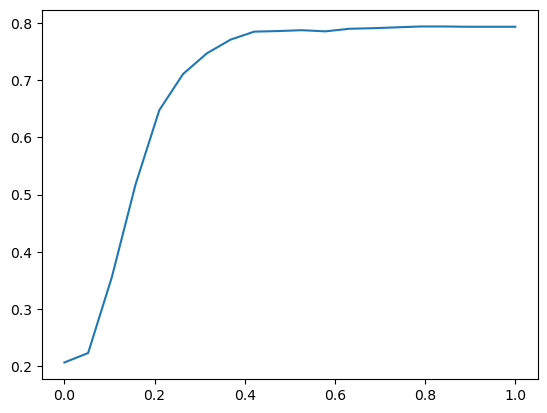

In [164]:
plt.plot(thresholds, scores)

#### Confusion Matrix

In [165]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [166]:
df_scores = confusion_matrix_dataframe(y_val, prediction)

In [167]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,414,1586,0,0
10,0.1,387,1292,27,294
20,0.2,281,624,133,962
30,0.3,148,261,266,1325
40,0.4,76,100,338,1486
50,0.5,33,47,381,1539
60,0.6,7,16,407,1570
70,0.7,2,8,412,1578
80,0.8,1,0,413,1586
90,0.9,0,0,414,1586


In [168]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

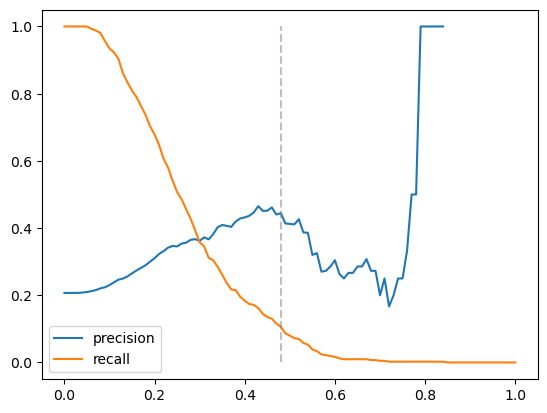

In [169]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

#### F1 Score

In [170]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [171]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.210000
tp            268.000000
fp            562.000000
fn            146.000000
tn           1024.000000
p               0.322892
r               0.647343
f1              0.430868
Name: 21, dtype: float64

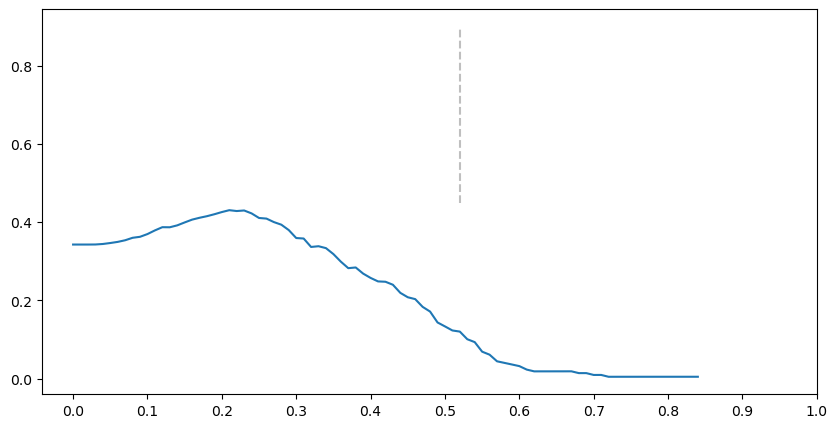

In [172]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.52, 0.45, 0.9, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### Cross-Validation

In [173]:
kfold = KFold(n_splits=10, shuffle=True , random_state=1)

In [176]:
for C in [0,0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20]:
    
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.exited.values
        y_val = df_val.exited.values

        dv,model = train(df_train, y_train, lr)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('%s %.3f +.. %.2f'%(C, np.mean(scores), np.std(scores)))

0 0.679 +.. 0.05
0.001 0.679 +.. 0.05
0.01 0.679 +.. 0.05
0.1 0.679 +.. 0.05
0.5 0.679 +.. 0.05
1 0.679 +.. 0.05
2 0.679 +.. 0.05
5 0.679 +.. 0.05
10 0.679 +.. 0.05
15 0.679 +.. 0.05
20 0.679 +.. 0.05


In [177]:
dv,model = train(df_full_train, df_full_train.exited.values,lr)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.6814192361345323

##### Hyperparameter Tuning

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0,0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.exited.values
        y_val = df_val.exited.values

        dv, model = train(df_train, y_train,lr, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, mean=%.3f, std=%.3f' % (C, np.mean(scores), np.std(scores)))

C=   0, mean=0.682, std=0.010
C=0.001, mean=0.682, std=0.010
C=0.01, mean=0.682, std=0.010
C= 0.1, mean=0.682, std=0.010
C= 0.5, mean=0.682, std=0.010
C=   1, mean=0.682, std=0.010
C=   2, mean=0.682, std=0.010
C=   5, mean=0.682, std=0.010
C=  10, mean=0.682, std=0.010


#### Insight: Logistic Regression doesn't perform well

In [266]:
len(y_val),len (y_test)

(1600, 2000)

### Model: DecisionTreeClassifier

### Model: RandomForestClassifier

In [220]:
train_dicts = df_train.to_dict(orient='records')
dv_new = DictVectorizer(sparse=True)
X_train = dv_new.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv_new.transform(val_dicts)

In [285]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rfc = RandomForestClassifier(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rfc.n_estimators = n
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict(X_val)
        score = roc_auc_score(y_val, y_pred)
        
        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators','roc_auc_score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [286]:
df_scores

,max_depth,n_estimators,roc_auc_score
0,10,10,0.998078
1,10,20,0.998078
2,10,30,0.998078
3,10,40,0.998078
4,10,50,0.998078
...,...,...,...
75,25,160,0.998078
76,25,170,0.998078
77,25,180,0.998078
78,25,190,0.998078


##### Insight: RandomForestClassififer perfoms better than LogisticRegression

### Model: XGBoostClassifier

In [1]:
import requests

In [2]:
url = "http://localhost:8080/predict"

In [4]:
customer={
    'customerid':15691111,
    'creditscore':648,
    'geography': 'Germany',
    'gender':'Female',
    'age':42,
    'tenure':8,
    'balance':121980.56,
    'numofproducts':2,
    'hascrcard':1,
    'isactivemember':0,
    'estimatedsalary':4027.02,
    'exited':0,
    'complain':0,
    'satisfaction_score': 1,
    'card_type':'GOLD',
    'point_earned':238

}

In [5]:
response = requests.post(url, json=customer)
response.json()

{'Churn Probablility': 0.021130952380952382, 'churn': False}